In [1]:
from pathlib import Path
from textwrap import fill

import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tiktoken
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [2]:
pip install openai tiktoken

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"  # paste your key here


In [4]:
from openai import OpenAI
client = OpenAI()

resp = client.chat.completions.create(
    model="gpt-4o",
    messages=[{"role": "user", "content": "Say 'API connection successful'"}],
    max_tokens=10
)

print(resp.choices[0].message.content)


API connection successful.


In [5]:
from openai import OpenAI
client = OpenAI()   # connects to OpenAI’s servers using your API key
MODEL = "gpt-4o"    # you can also try "gpt-4-turbo" or "gpt-3.5-turbo"
DATA_DIR = Path.cwd().parent / "data"

In [6]:
df = pd.read_csv(DATA_DIR / "/Users/asekibaala/Downloads/train.csv", index_col=0)

In [7]:
df

,text,summary
paper_id,,
0,## FROM SOVEREIGNTY TO EXTRATERRITORIAL CONSCI...,"In this article, Victor Fan argues that analys..."
1,## 1. Introduction\n\n\nAn Electronic Health R...,Problem definition: Physicians spend more than...
2,## Introduction\n\n\nTranslation plays an i...,Literary translation is one of the most challe...
3,## 1 Problem Setup\n\n\nRecent political scien...,There is a long-running debate on evaluating f...
4,## INTRODUCTION\n\n\nThis article investigat...,"Recently, ‘bimajyo’ (美魔女) came into focus in J..."
...,...,...
995,## Methods\n\n\n\n## Sample\n\n\nOur data come...,Demand for democratic accountability in polici...
996,## Introduction\n\n\nCanada is a high-income c...,Canada’s employment standards laws and mandato...
997,## Introduction\n\n\nCultural studies has ofte...,Cultural studies has often favoured a Foucauld...


text        0
summary     0
text_len    0
sum_len     0
dtype: int64
            text_len      sum_len
count    1000.000000  1000.000000
mean    42050.269000  1275.241000
std     21412.146068   426.262199
min     10145.000000    90.000000
25%     28381.500000  1008.500000
50%     38962.000000  1258.500000
75%     51263.250000  1501.250000
max    196911.000000  4359.000000


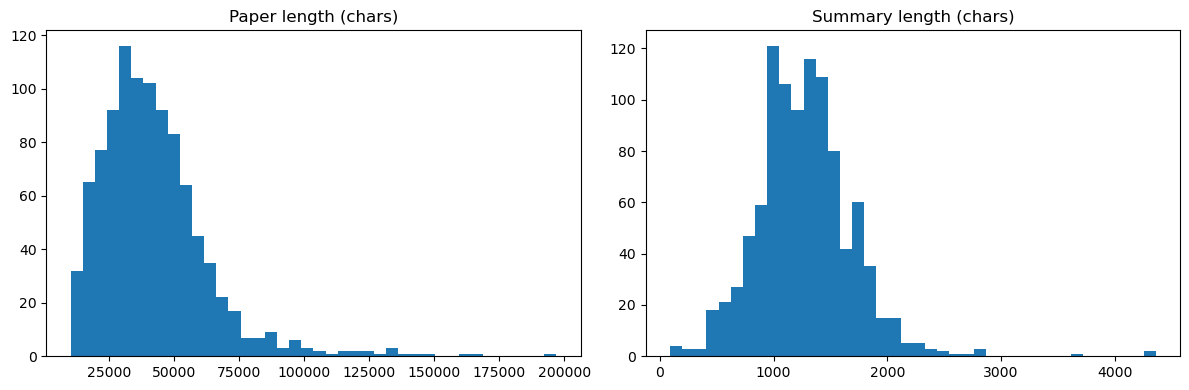

In [8]:
import matplotlib.pyplot as plt

df["text_len"] = df["text"].str.len()
df["sum_len"]  = df["summary"].str.len()

print(df.isnull().sum())
print(df[["text_len","sum_len"]].describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.hist(df["text_len"], bins=40); plt.title("Paper length (chars)")
plt.subplot(1,2,2); plt.hist(df["sum_len"],  bins=40); plt.title("Summary length (chars)")
plt.tight_layout(); plt.show()


In [9]:
from rouge_score import rouge_scorer

def rouge2_f1(pred: str, ref: str) -> float:
    scorer = rouge_scorer.RougeScorer(["rouge2"], use_stemmer=True)
    return scorer.score(ref, pred)["rouge2"].fmeasure

def evaluate_rouge2_mean(preds, refs):
    return sum(rouge2_f1(p, r) for p, r in zip(preds, refs)) / len(refs)


In [10]:
import re, math, networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

SENT_SPLIT_RE = re.compile(r'(?<=[.!?])\s+')

def split_sentences(text: str):
    sents = [s.strip() for s in SENT_SPLIT_RE.split(text) if s.strip()]
    return sents if sents else [text]

def textrank_extract(text: str, k: int = 5):
    sents = split_sentences(text)
    if len(sents) <= k:
        return " ".join(sents)
    tfidf = TfidfVectorizer().fit_transform(sents)
    sim = cosine_similarity(tfidf)
    g = nx.from_numpy_array(sim)
    scores = nx.pagerank(g)
    ranked = sorted(range(len(sents)), key=lambda i: scores[i], reverse=True)[:k]
    ranked.sort()
    return " ".join(sents[i] for i in ranked)

# quick check on a small sample
sample = df.sample(20, random_state=42)
preds = [textrank_extract(t, k=5) for t in sample["text"]]
score = evaluate_rouge2_mean(preds, sample["summary"].tolist())
print("Extractive baseline ROUGE-2 F1 (sample):", round(score, 4))


Extractive baseline ROUGE-2 F1 (sample): 0.1095


In [11]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4o")  # close enough tokenizer for counting

def count_tokens(s: str) -> int:
    return len(enc.encode(s))

def chunk_by_tokens(text: str, max_tokens: int = 1800, overlap_tokens: int = 100):
    tokens = enc.encode(text)
    chunks = []
    i = 0
    while i < len(tokens):
        j = min(i + max_tokens, len(tokens))
        chunk = enc.decode(tokens[i:j])
        chunks.append(chunk)
        i = j - overlap_tokens
        if i < 0: i = 0
        if i >= len(tokens): break
    return chunks


In [12]:
from openai import OpenAI
#LLM_SERVER = "http://localhost:11434"
MODEL = "gpt-4o"
#client = OpenAI(base_url=LLM_SERVER + "/v1", api_key="not-used")
client = OpenAI()

def llm_summarize_block(block: str, max_tokens: int = 500) -> str:
    prompt = (
        "You are a careful scientific writer.\n"
        "Write a single concise paragraph (3-6 sentences) that summarizes the core claims, methods, and findings.\n"
        "Do not include references, citations, or headings. Only use information from the text.\n\n"
        f"TEXT:\n{block}"
    )
    resp = client.chat.completions.create(
        model=MODEL,
        seed=0,
        messages=[{"role":"user","content":prompt}],
        max_tokens=max_tokens,
    )
    return resp.choices[0].message.content.strip()


In [13]:
#def summarize_long_doc(text: str) -> str:
    # 1) map: summarize chunks
    #chunks = chunk_by_tokens(text, max_tokens=1800, overlap_tokens=100)
    #partials = [llm_summarize_block(c, max_tokens=300) for c in chunks]

    # 2) reduce: summarize the partial summaries into one paragraph
    #reduce_input = "\n\n".join(partials)
    #final = llm_summarize_block(reduce_input, max_tokens=250)
    #return final


In [13]:
import gc, time

def summarize_long_doc(text: str) -> str:
    """Chunked summarization that writes each partial chunk immediately."""
    chunks = chunk_by_tokens(text, max_tokens=1000, overlap_tokens=50)
    partials = []

    for i, c in enumerate(chunks, start=1):
        print(f"   ↳ Summarizing chunk {i}/{len(chunks)} ...")
        try:
            summary_part = llm_summarize_block(c, max_tokens=250)
            partials.append(summary_part)
        except Exception as e:
            print(f" chunk {i} failed: {e}")
            partials.append("")
        gc.collect()
        time.sleep(1)   # brief pause to reduce API/CPU pressure

    # Reduce step: summarize the partial summaries only (tiny input)
    reduce_input = "\n\n".join(partials)
    print("   ↳ Combining partial summaries ...")
    final = llm_summarize_block(reduce_input[:6000], max_tokens=200)
    return final


In [ ]:
#from sklearn.model_selection import train_test_split

#train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Pick the summarizer you want to test:
#summ_fn = summarize_long_doc      #chatgpt-4o

#val_preds = [summ_fn(t) for t in val_df["text"]]
#val_score = evaluate_rouge2_mean(val_preds, val_df["summary"].tolist())
#print("Validation ROUGE-2 F1:", round(val_score, 4))


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Pick the summarizer you want to test:
summ_fn = summarize_long_doc      # using ChatGPT (gpt-4o)

val_preds = []
val_refs = val_df["summary"].tolist()

#  Process one document at a time to avoid memory overload
for i, text in enumerate(val_df["text"].head(5)):  # start with 5 for testing
    print(f"\n🔹 Summarizing paper {i+1}/{len(val_df)}...")
    try:
        summary = summ_fn(text)
        val_preds.append(summary)
    except Exception as e:
        print(f" Error on paper {i+1}: {e}")
        val_preds.append("")  # keep alignment if one fails

# Now evaluate
val_score = evaluate_rouge2_mean(val_preds, val_refs[:len(val_preds)])
print("\n✅ Validation ROUGE-2 F1:", round(val_score, 4))



🔹 Summarizing paper 1/150...
